<a href="https://colab.research.google.com/github/blasimark/DLtorch/blob/main/FashionMNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook aims to use the Fashion MNIST dataset for developing and testing various image classifier models. During testing I compare a set of four models against each other. The set consists of two pre-trained image classifiers (VGG16, ResNet50) and two models that were developed by me (a simple feedforward neural net and a CNN). 

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.data.dataset import random_split
import numpy as np
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device) 

cuda


# Load the dataset from torchvision and preprocess it

In [3]:
# both mean and std are estimates
mean = 0.3
std = 0.3
transform = transforms.Compose([transforms.Resize(size=224),transforms.Grayscale(num_output_channels=3), transforms.ToTensor(), transforms.Normalize(mean, std)])

batch_size = 100
input_dim = 224*224*3
output_dim = 10


train_valid_set = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_set = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)


size = len(train_valid_set)
train_size = int(0.8*size)
val_size = size - train_size

train_set, val_set = random_split(train_valid_set, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, num_workers=2)

classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Defining my own feedforward network

In [4]:
class FFNN(nn.Module): 
  def __init__(self):
    super(FFNN, self).__init__()

    self.linear_relu_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, output_dim),
    )

  def forward(self, x):
    x = self.linear_relu_stack(x)
    return x

# Define helper functions

In [5]:
# perform a single epoch of training

def train_step(model, loader, loss_fn, optimizer):
  model.train()

  total_loss = 0.0
  total_correct = 0
  N = 0 # total number of processed samples
  for inputs, labels in loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    N += inputs.size(0)

    total_loss += loss.item() * inputs.size(0)
    preds = outputs.argmax(dim=1)
    total_correct += (preds == labels).sum().item()
  
  mean_loss = total_loss / N
  mean_acc = total_correct / N
  print(f"Train loss: {mean_loss:.3f}\tTrain accuracy: {mean_acc:.3f}")

  return mean_loss, mean_acc


# perform a single epoch of validation
def eval_step(model, loader, loss_fn):

# no gradient computation is needed for evaluation, this reduces compute
  with torch.no_grad():
    model.eval()
    N = 0 # total number of processed samples

    total_loss = 0.0
    total_correct = 0

    for inputs, labels in loader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      N += inputs.size(0)

      total_loss += loss.item() * inputs.size(0)
      preds = outputs.argmax(dim=1)
      total_correct += (preds == labels).sum().item()

      preds = preds.data.cpu().numpy()
      labels = labels.data.cpu().numpy()

      y_true.extend(labels)
      y_pred.extend(preds)
    
    mean_loss = total_loss / N
    mean_acc = total_correct / N

  return mean_loss, mean_acc

# Combines the training and evaluation functions to perform the specified number of epochs. The function also keeps track of the validation accuracies of the model and saves the best weights
def train_and_eval(model, train_loader, val_loader, test_loader, loss_fn, optimizer, n_epochs):
  model.to(device)
  best_acc = 0.0
  best_model_wts = copy.deepcopy(model.state_dict())

  for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer)
    val_loss, val_acc = eval_step(model, val_loader, loss_fn)
    print(f"Validation loss: {val_loss:.3f}\tValidation accuracy: {val_acc:.3f}")
    print()

    if val_acc > best_acc:
      best_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_wts)

  test_loss, test_acc = eval_step(model, test_loader, loss_fn)

  print(f"Test loss: {test_loss:.3f}\tTest accuracy: {test_acc:.3f}")

# plots the confusion matrix-rows correspond to the true labels, columns to predictions
def plot_cm():
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix*10/np.sum(cf_matrix), index = [i for i in classes], columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.show()

# Training and testing the feedforward network

Epoch 1/10
Train loss: 0.575	Train accuracy: 0.793
Validation loss: 0.503	Validation accuracy: 0.821

Epoch 2/10
Train loss: 0.430	Train accuracy: 0.844
Validation loss: 0.435	Validation accuracy: 0.846

Epoch 3/10
Train loss: 0.398	Train accuracy: 0.857
Validation loss: 0.401	Validation accuracy: 0.861

Epoch 4/10
Train loss: 0.373	Train accuracy: 0.866
Validation loss: 0.403	Validation accuracy: 0.859

Epoch 5/10
Train loss: 0.362	Train accuracy: 0.869
Validation loss: 0.394	Validation accuracy: 0.866

Epoch 6/10
Train loss: 0.343	Train accuracy: 0.877
Validation loss: 0.377	Validation accuracy: 0.862

Epoch 7/10
Train loss: 0.336	Train accuracy: 0.878
Validation loss: 0.379	Validation accuracy: 0.870

Epoch 8/10
Train loss: 0.327	Train accuracy: 0.883
Validation loss: 0.376	Validation accuracy: 0.875

Epoch 9/10
Train loss: 0.329	Train accuracy: 0.881
Validation loss: 0.389	Validation accuracy: 0.861

Epoch 10/10
Train loss: 0.318	Train accuracy: 0.885
Validation loss: 0.370	Validat

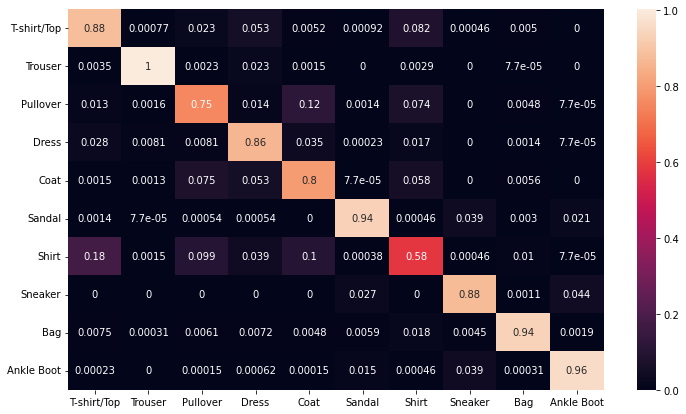

CPU times: user 2min 9s, sys: 1min 28s, total: 3min 38s
Wall time: 17min 25s


In [6]:
%%time

net = FFNN()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
n_epochs = 10
y_pred = []
y_true = []

train_and_eval(net, train_loader, val_loader, test_loader, loss_fn, optimizer, n_epochs)
plot_cm()

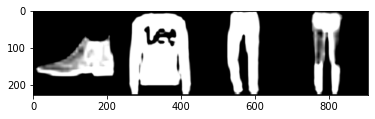

GroundTruth:  Ankle Boot Pullover Trouser Trouser
Predicted:  Ankle Boot Pullover Trouser Trouser


In [16]:
def imshow(img):
    img = img 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

# Defining my own convolutional neural network and testing it

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 5)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.fc1 = nn.Linear(89888, 128)
    self.fc2 = nn.Linear(128, 64)
    self.output = nn.Linear(64, output_dim)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    x = F.relu(x)

    x = self.output(x)

    return x

Epoch 1/10
Train loss: 0.558	Train accuracy: 0.797
Validation loss: 0.405	Validation accuracy: 0.857

Epoch 2/10
Train loss: 0.340	Train accuracy: 0.875
Validation loss: 0.329	Validation accuracy: 0.882

Epoch 3/10
Train loss: 0.286	Train accuracy: 0.895
Validation loss: 0.297	Validation accuracy: 0.894

Epoch 4/10
Train loss: 0.256	Train accuracy: 0.906
Validation loss: 0.296	Validation accuracy: 0.896

Epoch 5/10
Train loss: 0.221	Train accuracy: 0.918
Validation loss: 0.305	Validation accuracy: 0.895

Epoch 6/10
Train loss: 0.192	Train accuracy: 0.928
Validation loss: 0.313	Validation accuracy: 0.898

Epoch 7/10
Train loss: 0.166	Train accuracy: 0.938
Validation loss: 0.335	Validation accuracy: 0.898

Epoch 8/10
Train loss: 0.146	Train accuracy: 0.944
Validation loss: 0.297	Validation accuracy: 0.904

Epoch 9/10
Train loss: 0.120	Train accuracy: 0.955
Validation loss: 0.328	Validation accuracy: 0.902

Epoch 10/10
Train loss: 0.098	Train accuracy: 0.964
Validation loss: 0.310	Validat

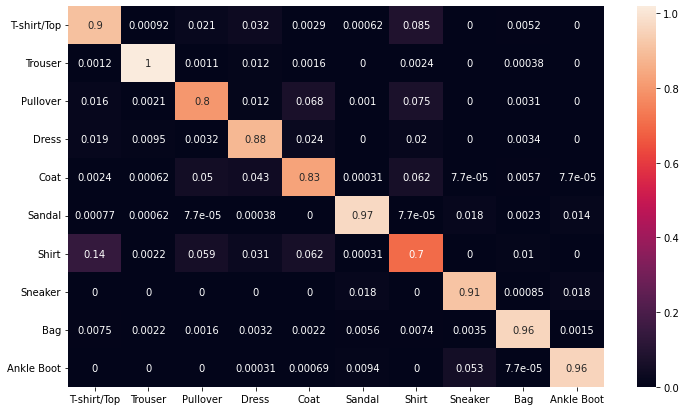

CPU times: user 6min 6s, sys: 1min 26s, total: 7min 32s
Wall time: 18min 25s


In [ ]:
%%time

net = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
n_epochs = 10

y_pred = []
y_true = []
train_and_eval(net, train_loader, val_loader, test_loader, loss_fn, optimizer, n_epochs)
plot_cm()

# Loading and testing VGG16

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoch 1/10
Train loss: 0.834	Train accuracy: 0.747
Validation loss: 0.489	Validation accuracy: 0.834

Epoch 2/10
Train loss: 0.763	Train accuracy: 0.776
Validation loss: 0.474	Validation accuracy: 0.838

Epoch 3/10
Train loss: 0.765	Train accuracy: 0.781
Validation loss: 0.492	Validation accuracy: 0.842

Epoch 4/10
Train loss: 0.748	Train accuracy: 0.785
Validation loss: 0.532	Validation accuracy: 0.822

Epoch 5/10
Train loss: 0.764	Train accuracy: 0.784
Validation loss: 0.462	Validation accuracy: 0.847

Epoch 6/10
Train loss: 0.752	Train accuracy: 0.788
Validation loss: 0.482	Validation accuracy: 0.846

Epoch 7/10
Train loss: 0.766	Train accuracy: 0.790
Validation loss: 0.425	Validation accuracy: 0.857

Epoch 8/10
Train loss: 0.768	Train accuracy: 0.789
Validation loss: 0.512	Validation accuracy: 0.834

Epoch 9/10
Train loss: 0.748	Train accuracy: 0.791
Validation loss: 0.464	Validation accuracy: 0.850

Epoch 10/10
Train loss: 0.743	Train accuracy: 0.792
Validation loss: 0.455	Validat

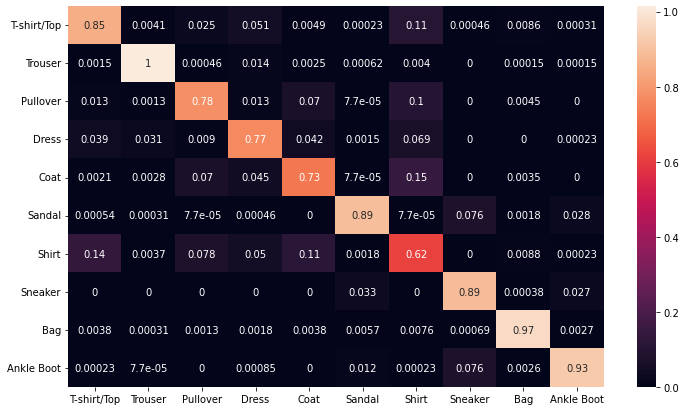

In [ ]:
vgg16 = models.vgg16(pretrained=True)

# freeze all parameters
for param in vgg16.parameters():
  param.requires_grad = False

vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, output_dim)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)
n_epochs = 10

y_pred = []
y_true = []
train_and_eval(vgg16, train_loader, val_loader, test_loader, loss_fn, optimizer, n_epochs)
plot_cm()

Epoch 1/10
Train loss: 0.632	Train accuracy: 0.785
Validation loss: 0.500	Validation accuracy: 0.824

Epoch 2/10
Train loss: 0.478	Train accuracy: 0.831
Validation loss: 0.482	Validation accuracy: 0.831

Epoch 3/10
Train loss: 0.443	Train accuracy: 0.843
Validation loss: 0.443	Validation accuracy: 0.842

Epoch 4/10
Train loss: 0.426	Train accuracy: 0.850
Validation loss: 0.436	Validation accuracy: 0.847

Epoch 5/10
Train loss: 0.407	Train accuracy: 0.855
Validation loss: 0.435	Validation accuracy: 0.847

Epoch 6/10
Train loss: 0.395	Train accuracy: 0.860
Validation loss: 0.399	Validation accuracy: 0.856

Epoch 7/10
Train loss: 0.392	Train accuracy: 0.860
Validation loss: 0.387	Validation accuracy: 0.861

Epoch 8/10
Train loss: 0.384	Train accuracy: 0.862
Validation loss: 0.381	Validation accuracy: 0.864

Epoch 9/10
Train loss: 0.370	Train accuracy: 0.866
Validation loss: 0.398	Validation accuracy: 0.860

Epoch 10/10
Train loss: 0.367	Train accuracy: 0.870
Validation loss: 0.389	Validat

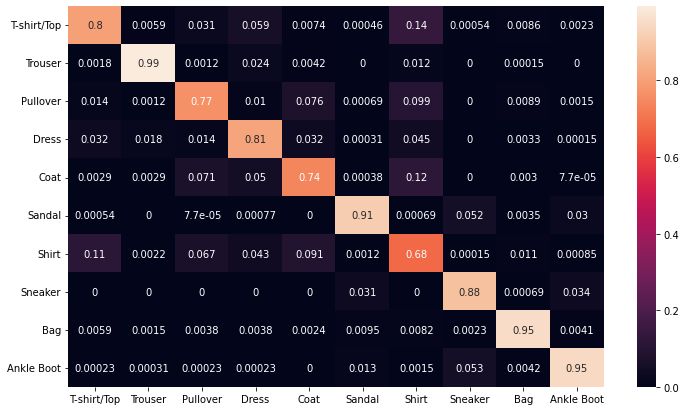

In [ ]:
resnet50 = models.resnet50(pretrained=True)

# freeze all parameters
for param in resnet50.parameters():
  param.requires_grad = False
  
resnet50.fc = nn.Linear(resnet50.fc.in_features, output_dim)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.01, momentum=0.9)
n_epochs = 10

y_pred = []
y_true = []
train_and_eval(resnet50, train_loader, val_loader, test_loader, loss_fn, optimizer, n_epochs)
plot_cm()

# According to the confusion matrices, most models mistake shirts for T-shirts/tops and coats for shirts (and vice versa). The best performing model is the custom CNN which significantly outperforms the other models on the training set and has the best accuracy on the test set with the chosen batch size and epoch number. 